<a href="https://colab.research.google.com/github/FaiazS/Variational_Auto_Encoder/blob/main/VariationalAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CELEBA DATASET


In [1]:
#Import libraraies

import numpy as np

import matplotlib.pyplot as plt

import os

import pickle

import tensorflow as tf

import keras.backend as k

from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape

from tensorflow.keras.layers import Lambda, Activation, BatchNormalization, LeakyReLU, Dropout

from keras.models import Model

from keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [2]:
class VariationalAutoencoder():

  def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size, encoder_conv_strides,

              decoder_conv_t_filters, decoder_conv_t_kernel_size, decoder_conv_t_strides, z_dim, use_dropout = False):


    self.name = 'Variational_Autoencoder'

    self.input_dim = input_dim                                  #Size of input image.

    self.encoder_conv_filters = encoder_conv_filters             #Encoder conv layer depth

    self.encoder_conv_kernel_size = encoder_conv_kernel_size      #Encoder conv kernel size

    self.encoder_conv_strides = encoder_conv_strides               #Encoder conv strides

    self.decoder_conv_t_filters = decoder_conv_t_filters    #Decoder conv transpose layer depth

    self.decoder_conv_t_kernel_size  = decoder_conv_t_kernel_size  #Decoder conv kernel size

    self.decoder_conv_t_strides = decoder_conv_t_strides #Decoder conv strides

    self.z_dim = z_dim             #Dimension of latent space

    self.use_dropout = use_dropout  #Apply dropouts or not

    self.build_variational_autoencoder()


In [3]:
import numpy as np
import keras.backend as k
from keras.layers import (Input, Conv2D, BatchNormalization, LeakyReLU, Dropout, Flatten, Dense, Lambda,
                          Reshape, Conv2DTranspose, Activation)
from keras.models import Model
from keras.optimizers import Adam

class VariationalAutoencoder:

    def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size, encoder_conv_strides,
                 decoder_conv_t_filters, decoder_conv_t_kernel_size, decoder_conv_t_strides,
                 z_dim, use_dropout=True, n_layers_encoder=3, n_layers_decoder=3):

        self.input_dim = input_dim

        self.encoder_conv_filters = encoder_conv_filters

        self.encoder_conv_kernel_size = encoder_conv_kernel_size

        self.encoder_conv_strides = encoder_conv_strides

        self.decoder_conv_t_filters = decoder_conv_t_filters

        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size

        self.decoder_conv_t_strides = decoder_conv_t_strides

        self.z_dim = z_dim

        self.use_dropout = use_dropout

        self.n_layers_encoder = n_layers_encoder

        self.n_layers_decoder = n_layers_decoder

        self.build_variational_autoencoder()

    def build_variational_autoencoder(self):

        """Builds the complete Variational Autoencoder (VAE) model."""

        # ---- ENCODER ----
        encoder_input = Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):

            x = Conv2D(filters=self.encoder_conv_filters[i],

                       kernel_size=self.encoder_conv_kernel_size[i],

                       strides=self.encoder_conv_strides[i],

                       padding='same',

                       name=f'encoder_conv_{i}')(x)

            x = BatchNormalization()(x)

            x = LeakyReLU()(x)

            if self.use_dropout:

                x = Dropout(rate=0.25)(x)

        shape_before_flattening = x.shape[1:]  # Save shape for later use in the decoder

        x = Flatten()(x)

        self.mu = Dense(self.z_dim, name='mu')(x)

        self.log_var = Dense(self.z_dim, name='log_var')(x)

        # Define the encoder model that outputs (mu, log_var)

        self.encoder_mu_log_var = Model(encoder_input, (self.mu, self.log_var))

        # Sampling function to obtain latent space representation

        def sampling(args):

            mu, log_var = args
            epsilon = k.random_normal(shape=k.shape(mu), mean=0, stddev=1)

            return mu + k.exp(log_var / 2) * epsilon

        # Latent space output

        encoder_output = Lambda(sampling, output_shape = (self.z_dim, ), name='encoder_output')([self.mu, self.log_var])

        # Full encoder model

        self.encoder = Model(encoder_input, encoder_output)

        # ---- DECODER ----

        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')

        x = Dense(np.prod(shape_before_flattening), activation='relu')(decoder_input)

        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):

            x = Conv2DTranspose(filters=self.decoder_conv_t_filters[i],

                                kernel_size=self.decoder_conv_t_kernel_size[i],

                                strides=self.decoder_conv_t_strides[i],

                                padding='same',

                                name=f'decoder_convolution_transpose_{i}')(x)

            if i < self.n_layers_decoder - 1:

                x = BatchNormalization()(x)

                x = LeakyReLU()(x)

                if self.use_dropout:

                    x = Dropout(rate=0.25)(x)
            else:

                x = Activation('sigmoid')(x)

        decoder_output = x

        self.decoder = Model(decoder_input, decoder_output)

        # ---- FULL VAE MODEL ----
        vae_model_input = encoder_input

        vae_model_output = self.decoder(encoder_output)

        self.model = Model(vae_model_input, vae_model_output)

    def compile(self, learning_rate, reconstruction_loss_factor):

        """Defines the loss function and compiles the VAE model."""

        self.learning_rate = learning_rate

        # ---- RECONSTRUCTION LOSS ----
        def vae_reconstruction_loss(y_true, y_pred):

            reconstruction_loss = k.mean(k.square(y_true - y_pred), axis=[1, 2, 3])

            return reconstruction_loss_factor * reconstruction_loss

        # ---- KL DIVERGENCE LOSS ----
        def vae_kl_loss(y_true, y_pred):

            kl_loss = -0.5 * k.sum(1 + self.log_var - k.square(self.mu) - k.exp(self.log_var), axis=1)

            return kl_loss

        # ---- COMBINED LOSS FUNCTION ----
        def variational_autoencoder_loss(y_true, y_pred):

            return vae_reconstruction_loss(y_true, y_pred) + vae_kl_loss(y_true, y_pred)

        # Optimizer
        optimizer = Adam(learning_rate=self.learning_rate)

        # Compile the model
        self.model.compile(optimizer=optimizer,

                           loss=variational_autoencoder_loss,

                           metrics=[vae_reconstruction_loss, vae_kl_loss])


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls /content/drive/My\ Drive/


 02_SM1_PLT_CG.pdf
 0f7ec2b2-7cee-4333-8078-886b320426a7.png
 100_Ecommerce_Experts_Share_Their_Secrets.pdf
'109474924_APR_2021(1).pdf'
 109474924_APR_2021.pdf
 109474924_AUG_2023.pdf
 109474924_JUN_2021.pdf
 109474924_JUN_2023.pdf
 109474924_MAY_2021.pdf
 109474924_NOV_2023.pdf
 109474924_OCT_2023.pdf
 109474924_SEP_2023.pdf
'10 AI Jobs to Apply in Hyderabad'
'10 AI Tools You Need to Know to Land Your Dream Job'
'10 Algorithms that Will Help You Succeed in Coding Interviews'
'10 Best YouTube Channels to learn Machine Learning'
'10 Data Science Companies to Work for in September 2023'
'10 Generative AI Trends to Watch Out for in 2024 and Beyond'
'10 Hardest Countries to Get Citizenship in the World 2023'
'10 Incredible Examples of AI-Generated Videos'
'10 Online Stores to Use as Inspiration for Your First Store.pdf'
'10 Open Source AI Platforms and Tools for Beginners and Experts'
'10+ Open-Source Tools for LLM Applications Development - MarkTechPost'
'10 Skills Required to Become a Pr

In [6]:
# Define the path where you want to create the folder

celeba_path = "/content/drive/My Drive/celeba"

if not os.path.exists(celeba_path):

  os.makedirs(celeba_path)

  print(f"Folder '{celeba_path}' created sucessfully")

else:

  print(f"Folder already exists")

Folder already exists


In [8]:
from glob import glob

IMAGE_FOLDER = "/content/drive/MyDrive/celeba/img_align_celeba/img_align_celeba"

INPUT_DIM = (128,128,3)

BATCH_SIZE = 32

filenames = np.array(glob(os.path.join(IMAGE_FOLDER, '*.jpg')))  # corrected path for glob

NUM_IMAGES = len(filenames)

LEARNING_RATE = 0.0005

RECONSTRUCTION_LOSS_FACTOR = 10000

EPOCHS = 10

if(NUM_IMAGES == 0):

  raise Exception("No images found. Check for correct path")

In [9]:
#Import Libraries for Image processing

from tensorflow.keras.preprocessing.image import ImageDataGenerator


data_generator = ImageDataGenerator(rescale = 1./255)
data_flow = data_generator.flow_from_directory(IMAGE_FOLDER, target_size = INPUT_DIM[:2],

                                               batch_size = BATCH_SIZE,

                                               shuffle = True,

                                               class_mode = 'input')

variational_auto_encoder = VariationalAutoencoder(input_dim = INPUT_DIM,

                                                  encoder_conv_filters = [32, 64, 64, 64],

                                                  encoder_conv_kernel_size = [3, 3, 3, 3],

                                                  encoder_conv_strides = [2, 2, 2 ,2],

                                                  decoder_conv_t_filters = [64, 64, 32, 3],

                                                  decoder_conv_t_kernel_size = [3, 3, 3, 3],

                                                  decoder_conv_t_strides = [2, 2, 2, 2],

                                                  z_dim = 200,

                                                  use_dropout = True

                                                  )

Found 0 images belonging to 0 classes.


In [10]:
variational_auto_encoder.encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv_0 (Conv2D)   │ (None, 64, 64, 32)     │            896 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 32)     │            128 │ encoder_conv_0[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 64, 64, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 32)     │              0 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv_1 (Conv2D)   │ (None, 32, 32, 64)     │         18,496 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ encoder_conv_1[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 64)     │              0 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_conv_2 (Conv2D)   │ (None, 16, 16, 64)     │         36,928 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 64)     │            256 │ encoder_conv_2[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 16, 16, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 16, 16, 64)     │              0 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 16384)          │              0 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mu (Dense)                │ (None, 200)            │      3,277,000 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ log_var (Dense)           │ (None, 200)            │      3,277,000 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_output (Lambda)   │ (None, 200)            │              0 │ mu[0][0],              │
│                           │                        │                │ log_var[0][0]          │
└──────────────────────

 Total params: 6,610,960 (25.22 MB)

 Trainable params: 6,610,640 (25.22 MB)

 Non-trainable params: 320 (1.25 KB)

In [11]:
variational_auto_encoder.decoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16384)               │       3,293,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_convolution_transpose_0      │ (None, 32, 32, 64)          │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_convolution_transpose_1      │ (None, 64, 64, 64)          │          36,928 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_convolution_transpose_2      │ (None, 128, 128, 32)        │          18,464 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 32)        │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,386,016 (12.92 MB)

 Trainable params: 3,385,760 (12.92 MB)

 Non-trainable params: 256 (1.00 KB)

In [12]:
#Compiling the VAE

variational_auto_encoder.compile(LEARNING_RATE, RECONSTRUCTION_LOSS_FACTOR)

checkpoint = ModelCheckpoint('weights_vae.weights.h5', save_weights_only = True) #Added Checkpoint definition.

def learning_rate_scheduler(epoch):

  if epoch < 5:

    return 0.0005

  else:

    return 0.0005 * np.exp(0.1 * (5 - epoch))  #Adjusted the learning rate scheduler.

In [13]:
#Training the VAE

variational_auto_encoder.model.fit(data_flow, shuffle = True, epochs = EPOCHS, steps_per_epoch = NUM_IMAGES // BATCH_SIZE, callbacks = [checkpoint, LearningRateScheduler(learning_rate_scheduler)])

#Loading the model post 50 epochs

variational_auto_encoder.model.load_weights("weights_vae.weights.h5")

variational_auto_encoder.model.fit(data_flow, shuffle = True, epochs = EPOCHS, steps_per_epoch = NUM_IMAGES // BATCH_SIZE, callbacks = [checkpoint, LearningRateScheduler(learning_rate_scheduler)])

variational_auto_encoder.model.load_weights('weights_vae.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: The PyDataset has length 0

In [ ]:
n_to_show = 30

znew = np.random.normal(size = (n_to_show, variational_auto_encoder.z_dim))

reconstruction = variational_auto_encoder.decoder.predict(znew)

fig = plt.figure(figsize = (18, 5))

fig.subplots.adjust(hspace = 0.4, wspace = 0.4)

for i in range(n_to_show):

  ax = fig.add_subplot(3, 10, i + 1)

  ax.imshow(reconstruction[i,:,:,:])

  ax.axis('off')

plt.show()


NameError: name 'variational_auto_encoder' is not defined

FASHION MNIST DATASET

In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import layers, models

In [15]:
#Loading and preprocessing the Fashion MNIST Dataset

(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

fashion_mnist = np.concatenate([x_train, x_test], axis = 0) #VAE does not require separate test data for evaluation, thus combining the training and test data(stacking them vertically)

fashion_mnist = np.expand_dims(fashion_mnist, - 1).astype("float32") / 255.0  #As the VAE Model expects 4D input (batch_size, height, width, channels)
                                                                              #Normalizing it to [0,1]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [16]:
#Define Latent Space Dimension - number of dimensions in which the VAE encodes the input images

latent_dim = 2

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 64)     │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 128)      │         73,856 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 6272)           │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 16)             │        100,368 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mean (Dense)              │ (None, 2)              │             34 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ log_var (Dense)           │ (None, 2)              │             34 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ mean[0][0],            │
│                           │                        │                │ log_var[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 174,932 (683.33 KB)

 Trainable params: 174,932 (683.33 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,633 (615.75 KB)

 Trainable params: 157,633 (615.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 292s 518ms/step - kl_loss: 3.4483 - loss: 393.6594 - reconstruction_loss: 390.2110
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 282s 515ms/step - kl_loss: 5.7709 - loss: 317.4942 - reconstruction_loss: 311.7233
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 322s 515ms/step - kl_loss: 5.5668 - loss: 307.1946 - reconstruction_loss: 301.6277
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 280s 512ms/step - kl_loss: 5.3622 - loss: 304.3879 - reconstruction_loss: 299.0256
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 322s 512ms/step - kl_loss: 5.3359 - loss: 301.8577 - reconstruction_loss: 296.5218
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 280s 513ms/step - kl_loss: 5.2442 - loss: 300.9457 - reconstruction_loss: 295.7015
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 321s 511ms/step - kl_loss: 5.1649 - loss: 299.5312 - reconstruction_loss: 294.3662
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 321s 509ms/step - kl_loss: 5.1549 - loss: 297.8517 - reconstruction_loss: 292.6967
Epoch 9/10
547/5

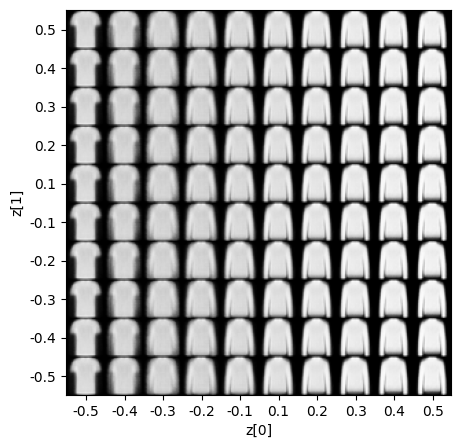

In [17]:
#Defining the VAE Model

class VAE(keras.Model):

  def __init__(self, encoder, decoder):

    super().__init__()

    self.encoder = encoder

    self.decoder = decoder

    self.total_loss_tracker = keras.metrics.Mean(name = 'total_loss')

    self.reconstruction_loss_tracker = keras.metrics.Mean(name = 'reconstruction_loss')

    self.kl_loss_tracker = keras.metrics.Mean(name = 'kl_loss')

  @property
  def metrics(self):

    return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]


  def train_step(self, data):

    with tf.GradientTape() as tape:  #Tensorflow's automatic differentiation tool - records operations on tensors to compute gradients later

     mean, log_var, z = self.encoder(data)  #mean and log var defines normal distribution for sampling, z is the sampled latent vector

     reconstruction = self.decoder(z)

     reconstruction_loss = tf.reduce_mean(

                                           tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis =(1, 2))

                                         )


     kl_loss = -0.5 * (1 + log_var - tf.square(mean) -  tf.exp(log_var))

     kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1))

     total_loss = reconstruction_loss + kl_loss

     grads = tape.gradient(total_loss, self.trainable_weights)

     self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

     self.total_loss_tracker.update_state(total_loss)

     self.reconstruction_loss_tracker.update_state(reconstruction_loss)

     self.kl_loss_tracker.update_state(kl_loss)

     return {


             "loss": self.total_loss_tracker.result(),

             "reconstruction_loss": self.reconstruction_loss_tracker.result(),

             "kl_loss" : self.kl_loss_tracker.result()

     }


#Sampling Layer to introduce Stochasticity in the latent space representation

#We are generating 1 random noise vector per sample in the batch

class Sampling(layers.Layer):

   #Sampling layer applies reparameterization trick to enable back-propagation

   def call(self, inputs):

    mean, log_var = inputs

    batch = tf.shape(mean)[0]

    dim = tf.shape(mean)[1]

    epsilon = tf.random.normal(shape = (batch, dim))  # mean and eplison must have the same shape so that the element-wise operations work correctly

    return mean + tf.exp(0.5 * log_var) * epsilon



#Defining Encoder

encoder_inputs = keras.Input(shape = (28, 28, 1 ))

x = layers.Conv2D(64, 3, activation = "relu", strides = 2, padding = 'same')(encoder_inputs)

x = layers.Conv2D(128, 3, activation = "relu", strides = 2, padding = 'same')(x)

x = layers.Flatten()(x)

x = layers.Dense(16, activation = "relu")(x)

mean = layers.Dense(latent_dim, name = "mean")(x)

log_var = layers.Dense(latent_dim, name = "log_var")(x)

z = Sampling()([mean, log_var])

encoder = keras.Model(encoder_inputs,[mean, log_var, z], name = "encoder")

encoder.summary()


#Defining Decoder

latent_inputs = keras.Input(shape = (latent_dim,))

x = layers.Dense(7 * 7 * 64, activation = "relu")(latent_inputs)

x = layers.Reshape((7, 7, 64))(x)

x = layers.Conv2DTranspose(128, 3, activation = "relu", strides = 2, padding = "same")(x)

x = layers.Conv2DTranspose(64, 3, activation = "relu", strides = 2, padding = "same")(x)

decoder_outputs = layers.Conv2DTranspose(1, 3, activation = "sigmoid", padding = "same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name = "decoder")

decoder.summary()

#Compiling and Training the VAE Model

vae = VAE(encoder, decoder)

vae.compile(optimizer = keras.optimizers.Adam())

vae.fit(fashion_mnist, epochs = 10, batch_size = 128)


#Function to visualize the latent space

def plot_latent_space(vae, n = 10, figsize = 5):

  img_size = 28

  scale = 0.5

  figure = np.zeros((img_size * n, img_size * n))

  grid_x = np.linspace(-scale, scale, n)

  grid_y = np.linspace(-scale, scale, n)[::-1]


  for i, yi in enumerate(grid_y):

    for j, xi in enumerate(grid_x):

      sample = np.array([[xi, yi]])

      x_decoded = vae.decoder.predict(sample, verbose = 0)

      images = x_decoded[0].reshape(img_size, img_size)

      figure[i * img_size: (i + 1) * img_size, j * img_size: (j + 1) * img_size] = images

  plt.figure(figsize = (figsize, figsize))

  start_range = img_size // 2

  end_range = n * img_size + start_range

  pixel_range = np.arange(start_range, end_range, img_size)

  sample_range_x = np.round(grid_x, 1)

  sample_range_y = np.round(grid_y, 1)

  plt.xticks(pixel_range, sample_range_x)

  plt.yticks(pixel_range, sample_range_y)

  plt.xlabel("z[0]")

  plt.ylabel("z[1]")

  plt.imshow(figure, cmap = "Greys_r")

  plt.show()

plot_latent_space(vae)


In [18]:
len(filenames)

5800